## Install & Import

###Define path

In [ ]:
from google.colab import drive
drive.mount('/content/drive' , force_remount=True)
path = '/content/drive/My Drive/Project AI'
path_txt = '/flickr_text/'
audio_path = '/flickr_audio/wavs/'

Mounted at /content/drive


In [ ]:
%cd /content/drive/My Drive/Project AI/pase-master

/content/drive/My Drive/Project AI/pase-master


###Install

In [ ]:
!pip install more-itertools

In [ ]:
!pip install --upgrade -r requirements.txt

  Cloning https://github.com/santi-pdp/ahoproc_tools.git to /tmp/pip-req-build-x8zgiyhs
  Running command git clone -q https://github.com/santi-pdp/ahoproc_tools.git /tmp/pip-req-build-x8zgiyhs
  Cloning https://github.com/salesforce/pytorch-qrnn to /tmp/pip-req-build-l77s71k4
  Running command git clone -q https://github.com/salesforce/pytorch-qrnn /tmp/pip-req-build-l77s71k4
  Cloning https://github.com/detly/gammatone to /tmp/pip-req-build-91xcgo3c
  Running command git clone -q https://github.com/detly/gammatone /tmp/pip-req-build-91xcgo3c
  Cloning https://github.com/pswietojanski/kaldi-io-for-python.git to /tmp/pip-req-build-mhx1ynyn
  Running command git clone -q https://github.com/pswietojanski/kaldi-io-for-python.git /tmp/pip-req-build-mhx1ynyn
Requirement already up-to-date: tqdm==4.28.1 in /usr/local/lib/python3.6/dist-packages (from -r requirements.txt (line 1)) (4.28.1)
Requirement already up-to-date: numpy==1.16.4 in /usr/local/lib/python3.6/dist-packages (from -r require

In [ ]:
!pip install torch==1.4.0 torchvision==0.5.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [ ]:
!python setup.py install

/usr/local/lib/python3.6/dist-packages/setuptools/dist.py:452: UserWarning: Normalizing '0.1.1-dev' to '0.1.1.dev0'
  warnings.warn(tmpl.format(**locals()))
running install
running bdist_egg
running egg_info
writing PASE.egg-info/PKG-INFO
writing dependency_links to PASE.egg-info/dependency_links.txt
writing top-level names to PASE.egg-info/top_level.txt
reading manifest file 'PASE.egg-info/SOURCES.txt'
writing manifest file 'PASE.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/pase
copying build/lib/pase/utils.py -> build/bdist.linux-x86_64/egg/pase
copying build/lib/pase/sbatch_writer.py -> build/bdist.linux-x86_64/egg/pase
copying build/lib/pase/__init__.py -> build/bdist.linux-x86_64/egg/pase
copying build/lib/pase/dataset.py -> build/bdist.linux-x86_64/egg/pase
copying build/lib/pase/log.py -> build/bdist.linux-x86_64/egg/pase
copying build

### Import

In [ ]:
import torch
import torchaudio
from more_itertools import chunked
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import math, copy, time, cupy
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
import spacy
from torchtext import data, datasets
import torch.optim as optim
import plotly.graph_objects as go
import time
import numpy as np
import string
import pandas as pd
import glob
from sklearn.utils import shuffle

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
from pase.models.frontend import wf_builder
pase = wf_builder('cfg/frontend/PASE+.cfg').eval()
pase.load_pretrained('FE_e199.ckpt', load_last=True, verbose=True)
pase = pase.to(device)

Current Model keys:  78
Current Pt keys:  78
Loading matching keys:  ['denseskips.0.weight', 'denseskips.1.weight', 'denseskips.2.weight', 'denseskips.3.weight', 'denseskips.4.weight', 'denseskips.5.weight', 'denseskips.6.weight', 'blocks.0.conv.low_hz_', 'blocks.0.conv.band_hz_', 'blocks.0.norm.weight', 'blocks.0.norm.bias', 'blocks.0.norm.running_mean', 'blocks.0.norm.running_var', 'blocks.0.norm.num_batches_tracked', 'blocks.0.act.weight', 'blocks.1.conv.weight', 'blocks.1.conv.bias', 'blocks.1.norm.weight', 'blocks.1.norm.bias', 'blocks.1.norm.running_mean', 'blocks.1.norm.running_var', 'blocks.1.norm.num_batches_tracked', 'blocks.1.act.weight', 'blocks.2.conv.weight', 'blocks.2.conv.bias', 'blocks.2.norm.weight', 'blocks.2.norm.bias', 'blocks.2.norm.running_mean', 'blocks.2.norm.running_var', 'blocks.2.norm.num_batches_tracked', 'blocks.2.act.weight', 'blocks.3.conv.weight', 'blocks.3.conv.bias', 'blocks.3.norm.weight', 'blocks.3.norm.bias', 'blocks.3.norm.running_mean', 'blocks.3

##Get data

###Create Dataframe for train, dev and test

In [ ]:
train_dev_test_split = {}

with open (path + path_txt + "Flickr_8k.devImages.txt",'r') as dev, open (path + path_txt + "Flickr_8k.testImages.txt",'r') as test, open (path + path_txt + "Flickr_8k.trainImages.txt",'r') as train:
        for line in dev:
                train_dev_test_split[line.strip().replace(".jpg","")] = "dev"
        for line in test:
                train_dev_test_split[line.strip().replace(".jpg","")] = "test"
        for line in train:
                train_dev_test_split[line.strip().replace(".jpg","")] = "train"
                
print(len(train_dev_test_split))
print(dict(list(train_dev_test_split.items())[0:2]))

8000
{'2090545563_a4e66ec76b': 'dev', '3393035454_2d2370ffd4': 'dev'}


In [ ]:
text_data = pd.read_csv(path + path_txt + 'Flickr8k.lemma.token.txt', header = None,sep='\t', dtype={'ID': str})
text_data.dropna(inplace = True) 
text_data = text_data.rename(columns={0: "Image", 1: "Description"})
text_data['ID'] = ""
text_data[['ID','NumAudio']] = text_data.Image.str.split("#",expand=True)
text_data['Image'] = text_data['ID']
text_data['ID'] = text_data['ID'].str.replace('.jpg','')

tdt = []
for x in text_data['ID']:
    if x in train_dev_test_split.keys():
        tdt.append(train_dev_test_split[x])
    else:
        tdt.append("Not_used")
text_data['TrainDevTest'] = tdt

text_data['ID'] = text_data['ID'] + '_' + text_data['NumAudio'] + '.wav'
text_data = text_data[['ID','Image','Description','TrainDevTest']]

print(text_data[text_data.TrainDevTest=='train'].shape[0])
print(text_data[text_data.TrainDevTest=='dev'].shape[0])
print(text_data[text_data.TrainDevTest=='test'].shape[0])

30000
5000
5000


In [ ]:
train_data = text_data[text_data.TrainDevTest=='train'][['ID','Image','Description']][:6000]
dev_data = text_data[text_data.TrainDevTest=='dev'][['ID','Image','Description']][:500]
test_data = text_data[text_data.TrainDevTest=='test'][['ID','Image','Description']][:500]

data_to_model = train_data[['ID','Description']]

print(train_data.head())
print(data_to_model.head())

                            ID  ...                                        Description
0  1305564994_00513f9a5b_0.wav  ...  A man in street racer armor be examine the tir...
1  1305564994_00513f9a5b_1.wav  ...         Two racer drive a white bike down a road .
2  1305564994_00513f9a5b_2.wav  ...  Two motorist be ride along on their vehicle th...
3  1305564994_00513f9a5b_3.wav  ...  Two person be in a small race car drive by a g...
4  1305564994_00513f9a5b_4.wav  ...       Two person in race uniform in a street car .

[5 rows x 3 columns]
                            ID                                        Description
0  1305564994_00513f9a5b_0.wav  A man in street racer armor be examine the tir...
1  1305564994_00513f9a5b_1.wav         Two racer drive a white bike down a road .
2  1305564994_00513f9a5b_2.wav  Two motorist be ride along on their vehicle th...
3  1305564994_00513f9a5b_3.wav  Two person be in a small race car drive by a g...
4  1305564994_00513f9a5b_4.wav       Two perso

In [ ]:
print(len(train_data))
print(len(dev_data))
print(len(test_data))

6000
500
500


##Vocabulary generation


###Text pre-processing

In [ ]:
def text_prep(sentence):
  return sentence.translate(str.maketrans('', '', string.punctuation)).lower() # remove punctuations, to lower case

### Vocabulary -> character level

In [ ]:
word_to_index = {}
index_to_word = {}
index = 0
max_len = 0 #max characters in one sentence

with open(path + "/flickr_text/Flickr8k.lemma.token.txt","r",encoding="utf-8",errors="ignore") as r:
    for line in r:
        sentence = text_prep(line.strip().split('\t')[1]) # sentence pre-processing
        chars = list(sentence) # get characters 
        if len(chars) > max_len:
          max_len = len(chars)
        for char in chars:
            if char not in word_to_index.keys():
                word_to_index[char] = index
                index_to_word[index] = char
                index+=1

SOS_TOKEN = "<s>"
EOS_TOKEN = "</s>"
PAD_TOKEN = "<pad>"

word_to_index[SOS_TOKEN] = index # add sos token
index_to_word[index] = SOS_TOKEN
index+=1

word_to_index[EOS_TOKEN] = index # add eos token
index_to_word[index] = EOS_TOKEN
index+=1

word_to_index[PAD_TOKEN] = index # add pad token
index_to_word[index] = PAD_TOKEN
PAD_INDEX = word_to_index[PAD_TOKEN]

vocab_size = len(word_to_index) # get vocabulary size
max_len+=2 # add one to max length for sentence end token

print(max_len)

184


In [ ]:
word_to_index

{' ': 1,
 '0': 32,
 '1': 31,
 '2': 30,
 '3': 29,
 '4': 28,
 '5': 27,
 '6': 33,
 '7': 36,
 '8': 35,
 '9': 34,
 '</s>': 38,
 '<pad>': 39,
 '<s>': 37,
 'a': 0,
 'b': 11,
 'c': 9,
 'd': 17,
 'e': 8,
 'f': 14,
 'g': 20,
 'h': 13,
 'i': 4,
 'j': 24,
 'k': 15,
 'l': 19,
 'm': 2,
 'n': 3,
 'o': 10,
 'p': 22,
 'q': 25,
 'r': 7,
 's': 5,
 't': 6,
 'u': 23,
 'v': 18,
 'w': 16,
 'x': 12,
 'y': 21,
 'z': 26}

## Encoder

###Encoder-No attention

In [ ]:
class Encoder_no_attention(nn.Module):

    def __init__(self, num_inp_channels, num_out_channels, encoder_final_size, 
               kernel_size = 7, stride = 3, pool_size = 3, dropout = 0.):
        super().__init__()
        #self.conv = nn.Conv1d(num_inp_channels, num_out_channels, kernel_size=kernel_size, stride=stride) # puede que no haga falta
        #self.relu = nn.ReLU() # puede que no haga falta
        #self.pool = nn.AvgPool1d(pool_size) #cambiar por average pooling
        #self.rnn = nn.GRU(num_out_channels, encoder_final_size, batch_first=True, dropout=dropout) 
        self.linear = nn.Linear(256,encoder_final_size)
    def forward(self, x):
        x = x.permute(0,2,1)
        x = torch.nn.functional.avg_pool2d(x, (x.shape[1], 1)).squeeze(1)
        x = self.linear(x)
        #x = x.permute(0,2,1)
        #x_final, _ = self.rnn(x)
        #x_final = x_final[:,-1]
        return x, x

###Encoder-Attention

In [ ]:
class Encoder_attention(nn.Module):

    def __init__(self, num_inp_channels, num_out_channels, encoder_final_size, kernel_size = 7, stride = 3, pool_size = 3):
        super().__init__()
        self.encoder_final_size = encoder_final_size
        self.conv = nn.Conv1d(num_inp_channels, num_out_channels, kernel_size=kernel_size, stride=stride) # puede que no haga falta
        self.relu = nn.ReLU() # puede que no haga falta
        self.maxpool = nn.AvgPool1d(pool_size) #cambiar por average pooling
        self.linear = nn.Linear(256,encoder_final_size)
        #self.rnn = nn.GRU(num_out_channels, encoder_final_size, batch_first=True, dropout=dropout) 

    def forward(self, x):
        x = self.maxpool(self.relu(self.conv(x)))
        x = x.permute(0,2,1)
        encoder_final = torch.nn.functional.avg_pool2d(x, (x.shape[1], 1)).squeeze(1) 
        encoder_final = self.linear(encoder_final)     
        #encoder_final = torch.zeros(x.size(0),self.encoder_final_size) #Use zeros as the encoder final when use attention; can be replaced by image vector

        return x, encoder_final

## Decoder

###Decoder-No attention

In [ ]:
class Decoder_no_attention(nn.Module): 
   
    def __init__(self, emb_size, encoder_final_size, hidden_size, vocab_size, num_layers=1, dropout=0.5):
        super(Decoder_no_attention, self).__init__()
        
        self.emb_size = emb_size # Word Embedding dimension 
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout
                 
        self.rnn = nn.GRU(emb_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
                 
        # Initialization from the final encoder state
        self.initialize_hidden = nn.Linear(encoder_final_size, hidden_size, bias=True) # change the size of encoding vector
        self.dropout_layer = nn.Dropout(p=dropout)
        self.pre_output_layer = nn.Linear(hidden_size + emb_size, hidden_size, bias=False)
        
    def forward_step(self, prev_embed, hidden):
        
        rnn_output, hidden = self.rnn(prev_embed, hidden)
        pre_output = torch.cat([prev_embed, rnn_output], dim=2)
        pre_output = self.dropout_layer(pre_output)
        pre_output = self.pre_output_layer(pre_output)

        return pre_output, hidden
    
    def forward(self, trg_embed, encoder_hidden, encoder_final, 
                max_len, hidden=None):
      
        if hidden is None:
            hidden = self.init_hidden(encoder_final)
            

        pre_output_vectors = [] # save all output vectors in an array
      
        for i in range(max_len):
            prev_embed = trg_embed[:, i].unsqueeze(1)
            pre_output, hidden = self.forward_step(prev_embed, hidden)
            pre_output_vectors.append(pre_output)

        pre_output_vectors = torch.cat(pre_output_vectors, dim=1) # output shape = (batch, sentence length, vocabulary size)
        return pre_output_vectors, hidden

    def init_hidden(self, encoder_final):
        if encoder_final is None:
            print('encoder_final none')
            return None
        return torch.tanh(self.initialize_hidden(encoder_final).unsqueeze(0).expand(self.num_layers,-1,-1)).to(device)

###Decoder-attention

In [ ]:
class AdditiveAttention(nn.Module):    
    def __init__(self, hidden_size, key_size=None, query_size=None):
        super(AdditiveAttention, self).__init__()
        
        # initialize key_size and query_size
        key_size = hidden_size if key_size is None else key_size
        query_size = hidden_size if query_size is None else query_size

        self.key_layer = nn.Linear(key_size, hidden_size, bias=False)
        self.query_layer = nn.Linear(query_size, hidden_size, bias=False)
        self.energy_layer = nn.Linear(hidden_size, 1, bias=False)

        self.alphas = None
        
    def forward(self, key=None, query=None, value=None):
        query = self.query_layer(query)

        scores = self.energy_layer(torch.tanh(query + key))
        scores = scores.squeeze(2).unsqueeze(1)
        
        alphas = F.softmax(scores, dim=-1)
        self.alphas = alphas               
        context = torch.bmm(alphas, value)
        
        return context, alphas

In [ ]:
class Decoder_with_attention(nn.Module): 
   
    def __init__(self, attention, emb_size, encoder_final_size, hidden_size, vocab_size, num_layers=2, dropout=0.5):
        super(Decoder_with_attention, self).__init__()
        
        self.emb_size = emb_size # Word Embedding dimension 
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.attention = attention
        self.dropout = dropout
                 
        self.rnn = nn.GRU(emb_size + hidden_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
                 
        # Initialization from the final encoder state
        self.initialize_hidden = nn.Linear(encoder_final_size, hidden_size, bias=True) # change the size of encoding vector
        self.dropout_layer = nn.Dropout(p=dropout)
        self.pre_output_layer = nn.Linear(2*hidden_size + emb_size, hidden_size, bias=False)
        self.output_feedforward_layer = nn.Linear(hidden_size, vocab_size, bias=True) # change the size of rnn output to the vocabulary size  
        
    def forward_step(self, prev_embed, encoder_hidden, key, hidden):
        
        query = hidden[-1].unsqueeze(1)
        context, attn_probs = self.attention(
            query=query, key=key,
            value=encoder_hidden)

        rnn_input = torch.cat([prev_embed, context], dim=2) # concatenate the previous word embedding with the context vector as the rnn input 
        rnn_output, hidden = self.rnn(rnn_input, hidden)

        pre_output = torch.cat([prev_embed, rnn_output, context], dim=2)
        pre_output = self.dropout_layer(pre_output)
        pre_output = self.pre_output_layer(pre_output)

        return pre_output, hidden
    
    def forward(self, trg_embed, encoder_hidden, encoder_final, 
                max_len, hidden=None):
      
        if hidden is None:
            hidden = self.init_hidden(encoder_final)

        key = self.attention.key_layer(encoder_hidden)

        pre_output_vectors = [] # save all output vectors in an array

        for i in range(max_len):
            prev_embed = trg_embed[:, i].unsqueeze(1)
            pre_output, hidden, = self.forward_step(prev_embed, encoder_hidden, key, hidden)
            pre_output_vectors.append(pre_output)

        pre_output_vectors = torch.cat(pre_output_vectors, dim=1) # output shape = (batch, sentence length, vocabulary size)
        return pre_output_vectors, hidden

    def init_hidden(self, encoder_final):
        if encoder_final is None:
            return None
        return torch.tanh(self.initialize_hidden(encoder_final).unsqueeze(0).expand(self.num_layers,-1,-1))

##Model

###Generator


In [ ]:
class Generator(nn.Module):
    def __init__(self, hidden_size, vocab_size):
        super(Generator, self).__init__()
        self.proj = nn.Linear(hidden_size, vocab_size, bias=False)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

###Encode-Decoder

In [ ]:
class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder, embedding, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.embedding = embedding
        self.generator = generator

    def forward(self, x, max_length, trg):
        encoder_hidden, encoder_final = self.encode(x)
        return self.decode(encoder_hidden, encoder_final,max_length, trg)
    
    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, encoder_hidden, encoder_final, max_length, trg, decoder_hidden=None):
        trg = trg.to(device)
        emb = self.embedding(trg)
        return self.decoder(emb, encoder_hidden, encoder_final,max_length, hidden=decoder_hidden)

###Initializer

In [ ]:
def init_model(emb_size, vocab_size, encoder_final_size=128, hidden_size=256, 
               num_layers=2, dropout=0.2, num_inp_channels=256, kernel_size=7, stride=3, pool_size=3, use_attention=True):

    if use_attention is True:
        attention = AdditiveAttention(hidden_size)
        model = EncoderDecoder(
            Encoder_attention(num_inp_channels, hidden_size, encoder_final_size, kernel_size, stride, pool_size),
            Decoder_with_attention(attention, emb_size, encoder_final_size, hidden_size, vocab_size, num_layers=num_layers, dropout=dropout),
            nn.Embedding(vocab_size, emb_size),
            Generator(hidden_size, vocab_size))
        model = model.to(device)
    else:
        model = EncoderDecoder(
            Encoder_no_attention(num_inp_channels, hidden_size, encoder_final_size, kernel_size, stride, pool_size, dropout=dropout),
            Decoder_no_attention(emb_size, encoder_final_size, hidden_size, vocab_size, num_layers=num_layers, dropout=dropout),
            nn.Embedding(vocab_size, emb_size),
            Generator(hidden_size, vocab_size))
        model = model.to(device)
    return model

##Greedy decoding

In [ ]:
def greedy_decoding(sentence_vector, max_len, index_to_word, eos=None):
  
    output = np.array([])
    for i in range(max_len):
      index = torch.argmax(sentence_vector[i]).item()  # get the word index
      output = np.append(output, index_to_word[index]) # use Index to word dict to find out the corresponding word
    
    if eos is not None:
      first_eos = np.where(output==eos)[0]   # if the end of sentence token found, cut the word list keeping only the tokens before
      if len(first_eos) > 0:
        output = output[:first_eos[0]]
    
    sentence = "".join(output).capitalize() # for character level tokens
    
    return sentence

## Loss

In [ ]:
class SimpleLossCompute:
    def __init__(self, criterion, generator, opt=None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt

    def __call__(self, x, y, norm):
        x = self.generator(x)
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)),
                              y.contiguous().view(-1))
        loss = loss / norm

        if self.opt is not None:
            loss.backward()          
            self.opt.step()
            self.opt.zero_grad()

        return loss.data.item() * norm

## Training Loop

In [ ]:
def addPadding(inputVector, size):
  if list(inputVector.shape)[2] < size:
    outputVector = torch.zeros(list(inputVector.shape)[0], list(inputVector.shape)[1], size) #Target
    outputVector[:, :, :inputVector.shape[2]] = inputVector
  else:
    outputVector = inputVector
  return outputVector

In [ ]:
def run_epoch(path_and_text_data, batch_size, model, loss_compute, print_every=200):
    start = time.time()
    total_tokens = 0
    total_loss = 0
    print_tokens = 0
    path_and_text_data = shuffle(path_and_text_data)
    path_and_text_data = path_and_text_data.reset_index(drop = True)
    
    path_and_text_data = path_and_text_data[['ID', 'Description']]
    data_to_model_tpl  = [tuple(x) for x in path_and_text_data.to_numpy()]  
    data = chunked(data_to_model_tpl, batch_size)

    for i, batch in enumerate(data):
      audios = [xx[0] for xx in batch]
      texts = [xx[1] for xx in batch]
      processed_audios = []
      batch_pase = None
      batch_texto = None #text for computing lost
      batch_texto_train = None #text for forward
      ntokens = 0
      audio_max = 0
      waveforms = []
      for z in audios:
        waveform, sample_rate = torchaudio.load(path + audio_path + z)      
        waveforms.append(waveform.T)
      waveform_batch = torch.nn.utils.rnn.pad_sequence(waveforms).to(device)

      batch_pase = pase(waveform_batch.permute(1,2,0))

      for u in texts:
        u = text_prep(u) # do the same pre-processing as in the extract vocabulary step 
        tokens = list(u) # character based
        tokens.append(EOS_TOKEN)
        ntokens += len(tokens)

        # create text for forward
        tokens_train = []
        for tkn in tokens:
          tokens_train.append(tkn) 
        tokens_train.insert(0,SOS_TOKEN) # insert the sentence start token
        text_train = [word_to_index[k] for k in tokens_train]
        pad_train = [PAD_INDEX] * (max_len - len(text_train))
        text_train.extend(pad_train) 
        text_train = torch.Tensor(text_train).type(torch.long) # text has size [max_len]
        text_train = text_train.view(1,text_train.size(0)) # change size to [1,max_len]
        text_train = text_train.to(device)
        batch_pase = batch_pase.to(device)
        if batch_texto_train is None:
          batch_texto_train = text_train
        else:
          batch_texto_train = torch.cat((batch_texto_train,text_train),0).to(device) # concatenate the target texts in the same batch

        #create text for loss computing
        tokens_y = []
        for tkn in tokens:
          tokens_y.append(tkn) 
        # no sentence start token here
        text_y = [word_to_index[k] for k in tokens_y]
        pad_y = [PAD_INDEX] * (max_len - len(text_y))
        text_y.extend(pad_y)
        text_y = torch.Tensor(text_y).type(torch.long).to(device) # text has size [max_len]
        text_y = text_y.view(1,text_y.size(0)) # change size to [1,max_len]
        if batch_texto is None:
          batch_texto = text_y
        else:
          batch_texto = torch.cat((batch_texto,text_y),0).to(device) # concatenate the target texts in the same batch
      

      out, _ = model.forward(batch_pase, max_len, batch_texto_train)

      loss = loss_compute(out, batch_texto, batch_size)
      total_loss += loss
      total_tokens += ntokens
      print_tokens += ntokens
 
      if model.training and i % print_every == 0:
        elapsed = time.time() - start
        print("Epoch Step: %d Loss: %f Tokens per Sec: %f Time spent (sec): %f" % (i, loss / batch_size, print_tokens / elapsed, elapsed))
        start = time.time()
        print_tokens = 0

        trg = texts[0]
        print("trg: ", texts[0])
        print("pred:", greedy_decoding(model.generator(out)[0], max_len, index_to_word, eos=EOS_TOKEN))

    return math.exp(total_loss / float(total_tokens))

##Training

### Define hyperparameters


In [ ]:
embedding_size = 125
batch_size = 10
learning_rate = 0.001
num_epochs = 6
print_every = 200

###Define train method


In [ ]:
def train(model, train_data, dev_data, num_epochs, lr, print_every, batch_size):    

    criterion = nn.NLLLoss(reduction="sum", ignore_index=PAD_INDEX)
    optim = torch.optim.Adam(model.parameters(), lr=lr)    #optimizer
    dev_perplexities = []

    for epoch in range(num_epochs):      
        print("Epoch", epoch)
        model.train()

        train_perplexity = run_epoch(train_data, batch_size, model,
                                     SimpleLossCompute(criterion, model.generator, optim),print_every=print_every)
        
        model.eval()
        
        with torch.no_grad():

            dev_perplexity = run_epoch(dev_data, batch_size,
                                       model, 
                                       SimpleLossCompute(criterion, model.generator, None), print_every=None)
            print("Validation perplexity: %f" % dev_perplexity)
            dev_perplexities.append(dev_perplexity)
  
        
    return dev_perplexities

###Define model

In [ ]:
model_no_attention = init_model(emb_size=embedding_size, vocab_size=vocab_size, encoder_final_size=128, hidden_size=256, num_layers=1, 
                                dropout=0.2, num_inp_channels=256, kernel_size=7, stride=3, pool_size=3, use_attention=False)

#Get a global view of total trainable parameters
pytorch_total_params = 0
for p in model_no_attention.parameters():
  pytorch_total_params += p.numel()
  if p.requires_grad:
    print(p.name, p.data.shape)
print("Total variables: " + str(pytorch_total_params))

None torch.Size([128, 256])
None torch.Size([128])
None torch.Size([768, 125])
None torch.Size([768, 256])
None torch.Size([768])
None torch.Size([768])
None torch.Size([256, 128])
None torch.Size([256])
None torch.Size([256, 381])
None torch.Size([40, 125])
None torch.Size([40, 256])
Total variables: 472840


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



In [ ]:
model = init_model(emb_size=embedding_size, vocab_size=vocab_size, encoder_final_size = 128, hidden_size=256, num_layers=1, 
                   dropout=0.2, num_inp_channels=256, kernel_size=7, stride=3, pool_size=3, use_attention=True)
#model = model.to(device)
#Get a global view of total trainable parameters
pytorch_total_params = 0
for p in model.parameters():
  pytorch_total_params += p.numel()
  if p.requires_grad:
    print(p.name, p.data.shape)
print("Total variables: " + str(pytorch_total_params))

None torch.Size([256, 256, 7])
None torch.Size([256])
None torch.Size([128, 256])
None torch.Size([128])
None torch.Size([256, 256])
None torch.Size([256, 256])
None torch.Size([1, 256])
None torch.Size([768, 381])
None torch.Size([768, 256])
None torch.Size([768])
None torch.Size([768])
None torch.Size([256, 128])
None torch.Size([256])
None torch.Size([256, 637])
None torch.Size([40, 256])
None torch.Size([40])
None torch.Size([40, 125])
None torch.Size([40, 256])
Total variables: 1335600


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



### Check drive




In [ ]:
waveform, sample_rate = torchaudio.load(path+audio_path+'667626_18933d713e_0.wav')

###Run this line to start training

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
torch.backends.cudnn.enabled = False

In [ ]:
dev_perplexities_no_attention = train(model_no_attention, train_data, dev_data, num_epochs=num_epochs,
                                      lr=learning_rate, print_every=print_every, batch_size = batch_size)

In [ ]:
dev_perplexities = train(model, train_data, dev_data, num_epochs=num_epochs, lr=learning_rate, 
                         print_every=print_every, batch_size = batch_size)

Epoch 0
Epoch Step: 0 Loss: 189.602356 Tokens per Sec: 236.084090 Time spent (sec): 2.143304
trg:  A bird with a long orange bill drink water .
pred: <s>77y<s>ux7ymfw7<pad>77yos7<pad>a7oscei<s>72etujou1p7iyyi3fsisssssfst0sssessshseis7usgssqssssh007ss0sh7sseslssss0rsss0ssshs4h0sslsesss7pse<pad>vgssqsse8cgtsssss90spssgs0sss78s0t900ltfssssssssg74sss7sss
Epoch Step: 200 Loss: 73.656677 Tokens per Sec: 329.847121 Time spent (sec): 308.703619
trg:  A man in a gray shirt be win a race in the grass .
pred: A bon on a brei bkirt be ritta bick 
Epoch Step: 400 Loss: 64.538170 Tokens per Sec: 314.451801 Time spent (sec): 323.496319
trg:  Basketball player push away opponent
pred: Aolketball player ilmt o  r 
Validation perplexity: 2.954104
Epoch 1
Epoch Step: 0 Loss: 44.628353 Tokens per Sec: 609.482394 Time spent (sec): 0.682546
trg:  Person ride a green race motorcycle .
pred: Aerson ride a sraen sace oatorcycle 
Epoch Step: 200 Loss: 52.120205 Tokens per Sec: 824.907972 Time spent (sec): 122.2

## Plot Perplexity

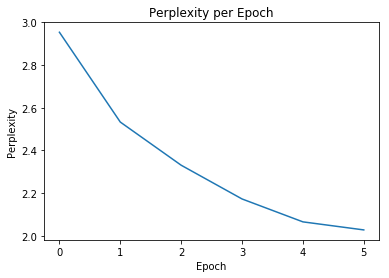

In [ ]:
def plot_perplexity(perplexities):
    """plot perplexities"""
    plt.title("Perplexity per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Perplexity")
    plt.plot(perplexities)
    
plot_perplexity(dev_perplexities)

##Save model

In [ ]:
#SAVE NO ATTENTION
#torch.save(model_no_attention.state_dict(), '/content/drive/My Drive/Project AI/models/model_no_attention_params_6k-8epochs.pkl')

In [ ]:
#SAVE ATTENTION
torch.save(model.state_dict(), '/content/drive/My Drive/Project AI/models/model_attention_params-6k-6epochs_125emb_0001lrate.pkl')

##Load model

In [ ]:
#LOAD NO ATTENTION
model_no_attention.load_state_dict(torch.load('/content/drive/My Drive/Project AI/models/model_no_attention_params_6k-8epochs.pkl'))
model_no_attention = model_no_attention.to(device)

In [ ]:
#LOAD ATTENTION
model.load_state_dict(torch.load('/content/drive/My Drive/Project AI/models/model_attention_params-6k-6epochs_125emb_0001lrate.pkl'))
model = model.to(device)

##Use model to predict

In [ ]:
predict_data = test_data[['ID','Description']]

In [ ]:
def model_pred_no_attention(model_no_attention, wav_file, max_len=100, sos_index=None, eos_index=None):
    with torch.no_grad():
        model_no_attention.eval()
        waveform, sample_rate = torchaudio.load(wav_file)       
        tensor_zeros = waveform.unsqueeze(1).to(device)
        pase_output = pase(tensor_zeros)
        encoder_hidden, encoder_final = model_no_attention.encode(pase_output)
        prev_y = torch.ones(1, 1).fill_(sos_index).type(torch.long)
        prev_y = prev_y.to(device)
        encoder_final = encoder_final.to(device)
        encoder_hidden = encoder_hidden.to(device)
        

    output = []
    hidden = None
    #print(model_no_attention.embedding(prev_y).shape)
    for i in range(max_len):
        with torch.no_grad():
            pre_output, hidden = model_no_attention.decode(encoder_hidden, encoder_final, 1, prev_y, hidden)
            prob = model_no_attention.generator(pre_output[:, -1])

        output.append(prob)
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.data.item()
        prev_y = torch.ones(1, 1).type(torch.long).fill_(next_word)

    return (greedy_decoding(output, max_len, index_to_word, eos=EOS_TOKEN))

In [ ]:
a=[]
results_original_no_att=pd.DataFrame()
#aux = predict_data
#aux = aux[0:20]
predict_data_list = predict_data['ID'].tolist()
for i in predict_data_list:
    res = model_pred_no_attention(model_no_attention, path + audio_path + i, max_len, word_to_index[SOS_TOKEN], word_to_index[EOS_TOKEN])
    original = predict_data[predict_data['ID']==i]
    original = original[['Description']]
    a.append(res)
    results_original_no_att = results_original_no_att.append(original)

results_pred_no_att = pd.DataFrame(a)

##Save to txt
results_pred_no_att.to_csv('/content/drive/My Drive/Project AI/models/results_no_att.txt', index = False, header=False)
results_original_no_att.to_csv('/content/drive/My Drive/Project AI/models/originals_no_att.txt', index = False, header=False)

In [ ]:
model_pred_no_attention(model_no_attention, path+audio_path+'166507476_9be5b9852a_0.wav', max_len, word_to_index[SOS_TOKEN], word_to_index[EOS_TOKEN])

'A man in a black dog be ride a skateboard '

In [ ]:
def model_pred(model, wav_file, max_len=100, sos_index=None, eos_index=None):
    with torch.no_grad():
        model.eval()
        waveform, sample_rate = torchaudio.load(wav_file)       
        tensor_zeros = waveform.unsqueeze(1).to(device)
        pase_output = pase(tensor_zeros)
        encoder_hidden, encoder_final = model.encode(pase_output)
        encoder_final =encoder_final.to(device)
        encoder_hidden = encoder_hidden.to(device)
        prev_y = torch.ones(1, 1).fill_(sos_index).type(torch.long)
        prev_y = prev_y.to(device)

    output = []
    hidden = None
    ##print(model.embedding(prev_y).shape)
    for i in range(max_len):
        with torch.no_grad():
            pre_output, hidden = model.decode(encoder_hidden, encoder_final,1, prev_y, hidden)
            prob = model.generator(pre_output[:, -1])

        output.append(prob)
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.data.item()
        prev_y = torch.ones(1, 1).type(torch.long).fill_(next_word)

    return (greedy_decoding(output, max_len, index_to_word, eos=EOS_TOKEN))

In [ ]:
a=[]
results_original_att=pd.DataFrame()
predict_data_list = predict_data['ID'].tolist()
for i in predict_data_list:
    res = model_pred(model, path + audio_path + i, max_len, word_to_index[SOS_TOKEN], word_to_index[EOS_TOKEN])
    original = predict_data[predict_data['ID']==i]
    original = original[['Description']]
    a.append(res)
    results_original_att = results_original_att.append(original)

results_pred_att = pd.DataFrame(a)

##Save to txt
results_pred_att.to_csv('/content/drive/My Drive/Project AI/models/results_att.txt', index = False, header=False)
results_original_att.to_csv('/content/drive/My Drive/Project AI/models/originals_att.txt', index = False, header=False)

In [ ]:
model_pred(model,path+audio_path+'166507476_9be5b9852a_0.wav',max_len,word_to_index[SOS_TOKEN],word_to_index[EOS_TOKEN])

'Fire boy be ride a water bottle with water '

## WER

In [ ]:
!pip install asr-evaluation

In [ ]:
#WER NO ATTENTION
!wer "/content/drive/My Drive/Project AI/models/originals_no_att.txt" "/content/drive/My Drive/Project AI/models/results_no_att.txt"

Sentence count: 500
WER:   112.523% (      6146 /       5462)
WRR:    17.063% (       932 /       5462)
SER:   100.000% (       500 /        500)


In [ ]:
#WER ATTENTION
!wer "/content/drive/My Drive/Project AI/models/originals_att.txt" "/content/drive/My Drive/Project AI/models/results_att.txt"

Sentence count: 500
WER:    71.531% (      3907 /       5462)
WRR:    33.614% (      1836 /       5462)
SER:    99.800% (       499 /        500)
